# Open Street Map

In [57]:
import osmnx as ox 
import matplotlib.pyplot as plt
#from load_data import *
#import helpers
import geopandas
import pandas as pd

from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import Point
from shapely.geometry import LineString

from scipy import spatial
from scipy.spatial import KDTree

from statistics import mean

import geopy 
import geopy.distance

import seaborn as sns

import numpy as np

Working with AirBnB Data; but it seems to be older code?
https://towardsdatascience.com/a-guide-turning-openstreetmap-location-data-into-ml-features-e687b66db210

In [58]:
url_listing = "http://data.insideairbnb.com/germany/bv/munich/2021-12-24/data/listings.csv.gz"
listings = pd.read_csv(url_listing)

In [59]:
listings[["latitude", "longitude"]].isna().sum()

latitude     0
longitude    0
dtype: int64

In [60]:
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
price = pd.DataFrame(price)
price["log_price"] = np.log(price)
price["id"] = listings["id"]
price = price[["id", "price", "log_price"]]

C:\Users\49173\anaconda3\envs\geo2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [61]:
# Prepare osm_dataframe
listings_osm = pd.DataFrame(listings["id"])

#turn listings in geopandas object
gdf = geopandas.GeoDataFrame(
    listings, geometry=geopandas.points_from_xy(listings.longitude, listings.latitude))

# Relevant area

The AirBnB's are not all within the city center. Let's get a overview over the relevant area.

In [62]:
# Inland Water
# Set up query
query = {'natural':'water'}

#Run query, # does not work
water_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

In [63]:
# Coastline
# Set up query
query = {'natural':'coastline'}

#Run query, # does not work
coastline_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

In [64]:
# Trees
# Set up query
query = {'natural':'wood'}

#Run query, # does not work
wood_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

In [65]:
# National Park
# Set up query
query = {'boundary':'national_park'}

#Run query, # does not work
park_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

In [66]:
# Forest
# Set up query
query = {'landuse':'forest'}

#Run query, # does not work
forest_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

In [67]:
# City Parks
# Set up query
query = {'leisure':'park'}

#Run query, # does not work
parks_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

## Map

C:\Users\49173\anaconda3\envs\geo2\lib\site-packages\geopandas\plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\49173\anaconda3\envs\geo2\lib\site-packages\geopandas\plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


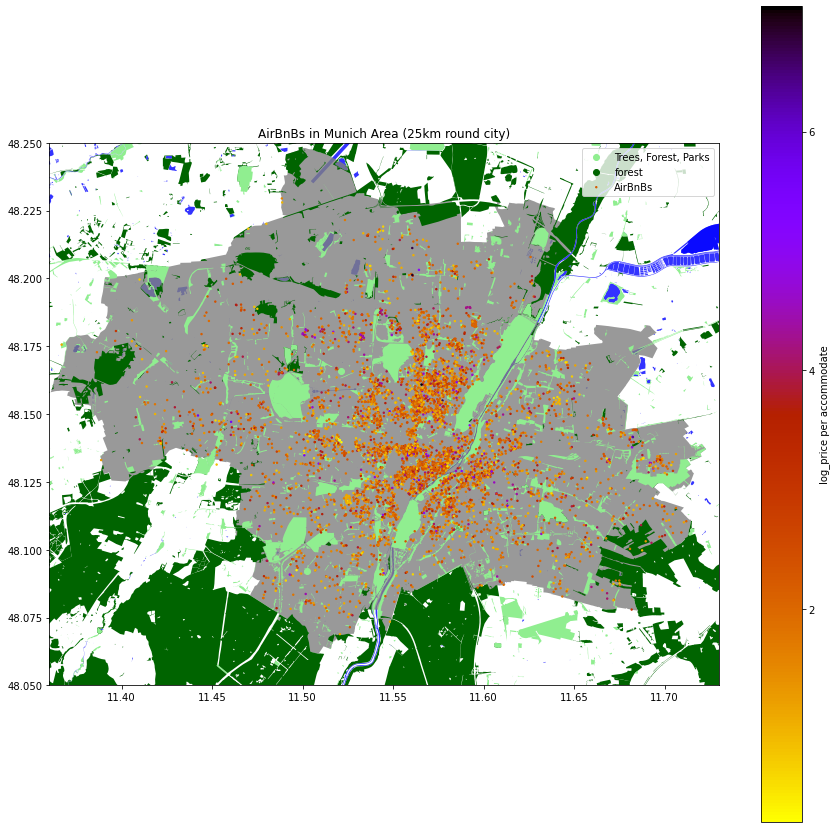

In [68]:
munich_area_gdf = ox.geocode_to_gdf("München, Bayern, Deutschland", buffer_dist=1000)
munich_gdf = ox.geocode_to_gdf("München, Bayern, Deutschland")

plotdf = pd.concat([gdf, price], axis = 1)
plotdf["log_price_pP"] = plotdf["log_price"] / plotdf["accommodates"]
# Set up a plot axis
fig, ax = plt.subplots(figsize = (15,15))

# Visualise both on the plot
munich_area_gdf.plot(ax = ax, alpha = 0.3, color = "white")
water_gdf.plot(ax=ax, color = "blue", alpha = 0.8, label = "water")
coastline_gdf.plot(ax=ax, color="darkblue", label ="coastline" )
munich_gdf.plot(ax = ax, alpha = 0.8, color = "grey", label = 'Munich City')
wood_gdf.plot(ax=ax, color ="lightgreen", alpha = 1, label = "Trees, Forest, Parks")
park_gdf.plot(ax=ax, color ="lightgreen", alpha = 1)
forest_gdf.plot(ax=ax, color ="darkgreen", alpha = 1, label ="forest")
parks_gdf.plot(ax=ax, color ="lightgreen", alpha = 1)#, label ="city parks")
plt.scatter(plotdf.longitude, plotdf.latitude, s = 2, c=plotdf["log_price_pP"], cmap="gnuplot_r", label = "AirBnBs")
plt.legend()
plt.title("AirBnBs in Munich Area (25km round city)")
ax.set_xlim(11.36, 11.73)
ax.set_ylim(48.05, 48.25)

plt.colorbar(location = "right", orientation = "vertical", 
                label = "log_price per accommodate", ticks=range(0, 10, 2))

# First OSM-Data from map

In [69]:
# in city?
listings_osm["in_city"] = gdf["geometry"].apply(lambda x: munich_gdf.geometry.contains(x))

In [70]:
listings_osm["in_city"] = listings_osm["in_city"].astype(int)

# Number of anemities in 10 minute walk

first needed functions and coords

In [71]:
# The earth is round, that is why we need to convert coordinates into local projections

def get_local_crs(y,x):  
    x = ox.utils_geo.bbox_from_point((y, x), dist = 25000, project_utm = True, return_crs = True)
    return x[-1]

def find_points_closeby(lat_lon, k = 500, max_distance = 1000):
  
  results = tree.query((lat_lon), k = k, distance_upper_bound= max_distance)
  zipped_results = list(zip(results[0], results[1]))
  zipped_results = [i for i in zipped_results if i[0] != np.inf]
  
  return len(zipped_results)
  
# Set Dublin longitude and latitude
#https://latitude.to/map/de/germany/cities/munich
lon_latitude = 48.13743
lon_longitude = 11.57549

local_utm_crs = get_local_crs(lon_latitude, lon_longitude)

air_gdf = geopandas.GeoDataFrame(listings, geometry = geopandas.points_from_xy(listings.longitude, listings.latitude), crs = 4326)
air_gdf = air_gdf.to_crs(local_utm_crs)

## Sustenances

look here: https://wiki.openstreetmap.org/wiki/Map_features#Facilities

In [72]:
# Set up query
query = {'amenity': ["bar", "biergarten", "pub"]}

#Run query, # does not work
bar_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

bar_gdf['geometry'] = bar_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
bar_gdf['geometry'] = bar_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
bar_gdf = bar_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = bar_gdf.geometry.apply(lambda x: x.x).values
Lat = bar_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['bars'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [73]:
# Set up query
query = {'amenity': "cafe"}

#Run query, # does not work
cafe_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

cafe_gdf['geometry'] = cafe_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
cafe_gdf['geometry'] = cafe_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
cafe_gdf = cafe_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = cafe_gdf.geometry.apply(lambda x: x.x).values
Lat = cafe_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['cafes'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [74]:
# Set up query
query = {'amenity': "fast_food"}

#Run query, # does not work
fast_food_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

fast_food_gdf['geometry'] = fast_food_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
fast_food_gdf['geometry'] = fast_food_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
fast_food_gdf = fast_food_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = fast_food_gdf.geometry.apply(lambda x: x.x).values
Lat = fast_food_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['fast_foods'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [75]:
# Set up query
query = {'amenity': "restaurant"}

#Run query, # does not work
restaurant_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

restaurant_gdf['geometry'] = restaurant_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
restaurant_gdf['geometry'] = restaurant_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
restaurant_gdf = restaurant_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = restaurant_gdf.geometry.apply(lambda x: x.x).values
Lat = restaurant_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['restaurants'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

array([[<AxesSubplot:title={'center':'in_city'}>,
        <AxesSubplot:title={'center':'bars'}>],
       [<AxesSubplot:title={'center':'cafes'}>,
        <AxesSubplot:title={'center':'fast_foods'}>],
       [<AxesSubplot:title={'center':'restaurants'}>, <AxesSubplot:>]],
      dtype=object)

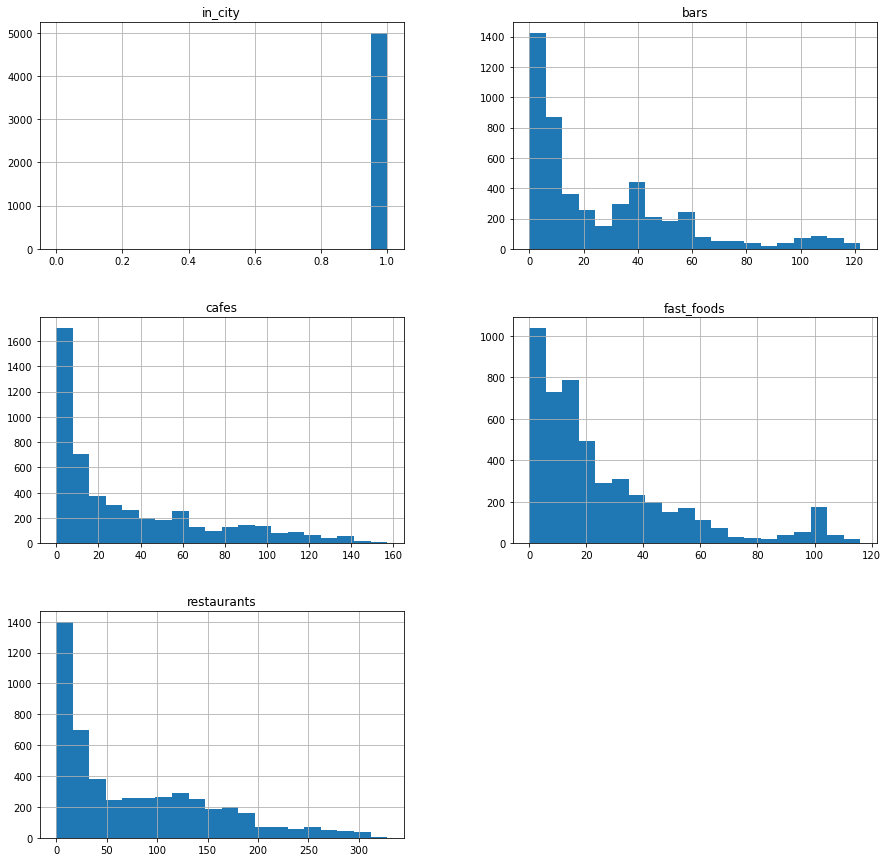

In [76]:
listings_osm[['in_city', 'bars', 'cafes', 'fast_foods', 'restaurants']].hist(figsize=(15,15), bins = 20)

## Education

In [77]:
# Set up query
query = {'amenity': "library"}

#Run query, # does not work
library_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

library_gdf['geometry'] = library_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
library_gdf['geometry'] = library_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
library_gdf = library_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = library_gdf.geometry.apply(lambda x: x.x).values
Lat = library_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['library'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [78]:
# Set up query
query = {'amenity': ["university", "college"]}

#Run query, # does not work
university_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

university_gdf['geometry'] = university_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
university_gdf['geometry'] = university_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
university_gdf = university_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = university_gdf.geometry.apply(lambda x: x.x).values
Lat = university_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['university'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

array([[<AxesSubplot:title={'center':'library'}>,
        <AxesSubplot:title={'center':'university'}>]], dtype=object)

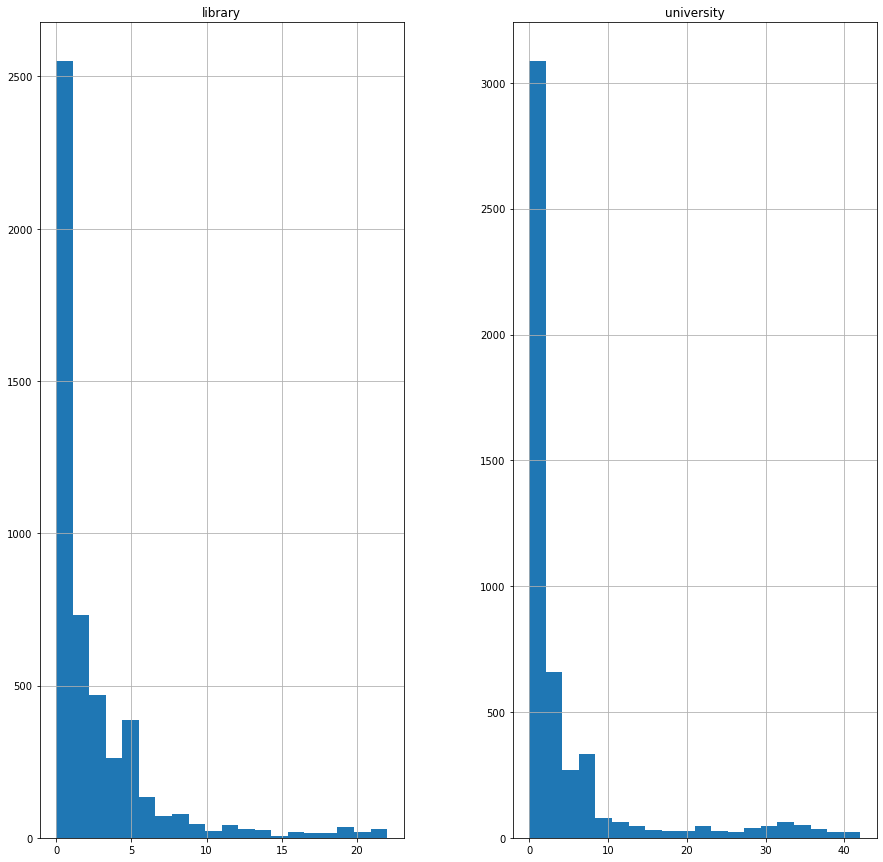

In [79]:
listings_osm[["library", "university"]].hist(figsize=(15,15), bins = 20)

## Transportation

In [80]:
# Set up query
query = {'amenity': "bus_station",
        "public_transport" : ["stop_position", "stop_area", "station"],
        'railway': "tram_stop"}

#Run query, # does not work
bus_train_tram_station_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

bus_train_tram_station_gdf['geometry'] = bus_train_tram_station_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
bus_train_tram_station_gdf['geometry'] = bus_train_tram_station_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
bus_train_tram_station_gdf = bus_train_tram_station_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = bus_train_tram_station_gdf.geometry.apply(lambda x: x.x).values
Lat = bus_train_tram_station_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['bus_train_tram_station'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [81]:
# Set up query
query = {'amenity': "bicycle_rental"}

#Run query, # does not work
bicycle_rental_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

bicycle_rental_gdf['geometry'] = bicycle_rental_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
bicycle_rental_gdf['geometry'] = bicycle_rental_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
bicycle_rental_gdf = bicycle_rental_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = bicycle_rental_gdf.geometry.apply(lambda x: x.x).values
Lat = bicycle_rental_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['bicycle_rentals'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [82]:
# Set up query
query = {'amenity': "ferry_terminal"}

#Run query, # does not work
ferry_terminal_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

ferry_terminal_gdf['geometry'] = ferry_terminal_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
ferry_terminal_gdf['geometry'] = ferry_terminal_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
ferry_terminal_gdf = ferry_terminal_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = ferry_terminal_gdf.geometry.apply(lambda x: x.x).values
Lat = ferry_terminal_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['ferry_terminal'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

ValueError: data must be 2 dimensions

In [86]:
listings_osm['ferry_terminal'] = 0

In [88]:
# Set up query
query = {'amenity': "parking"}

#Run query, # does not work
parking_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

parking_gdf['geometry'] = parking_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
parking_gdf['geometry'] = parking_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
parking_gdf = parking_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = parking_gdf.geometry.apply(lambda x: x.x).values
Lat = parking_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['parking'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [89]:
# Set up query
query = {'amenity': "taxi"}

#Run query, # does not work
taxi_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

taxi_gdf['geometry'] = taxi_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
taxi_gdf['geometry'] = taxi_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
taxi_gdf = taxi_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = taxi_gdf.geometry.apply(lambda x: x.x).values
Lat = taxi_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['taxi'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

array([[<AxesSubplot:title={'center':'bus_train_tram_station'}>,
        <AxesSubplot:title={'center':'bicycle_rentals'}>],
       [<AxesSubplot:title={'center':'ferry_terminal'}>,
        <AxesSubplot:title={'center':'parking'}>],
       [<AxesSubplot:title={'center':'taxi'}>, <AxesSubplot:>]],
      dtype=object)

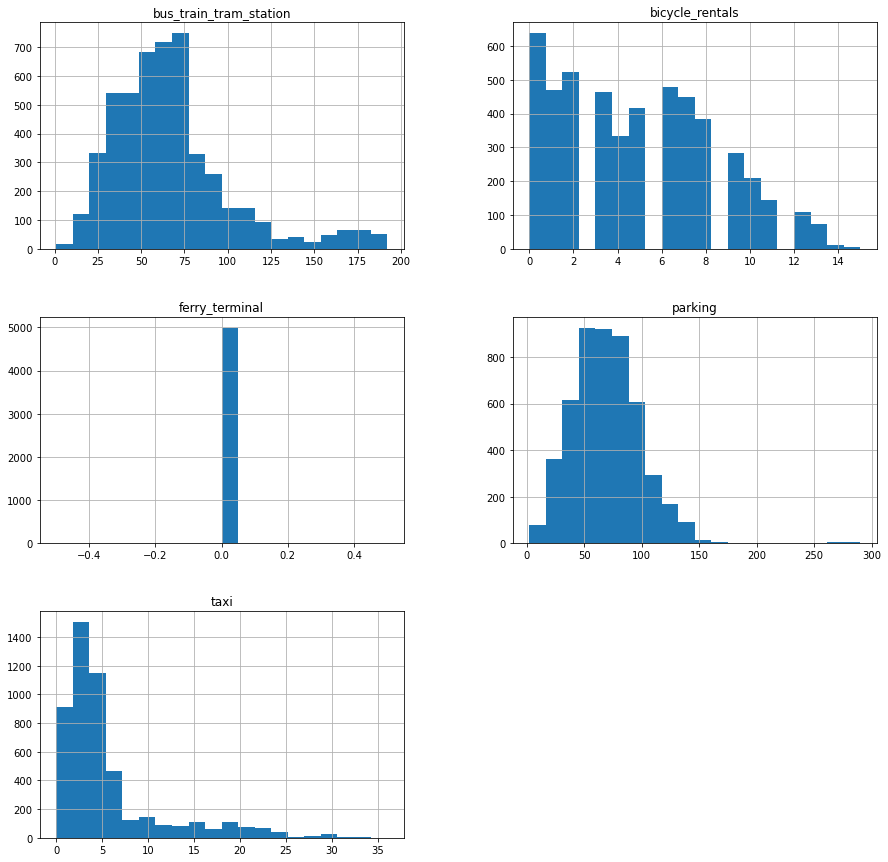

In [90]:
listings_osm[['bus_train_tram_station', 'bicycle_rentals', 'ferry_terminal', 
              'parking', 'taxi']].hist(bins = 20, figsize=(15,15))

<AxesSubplot:>

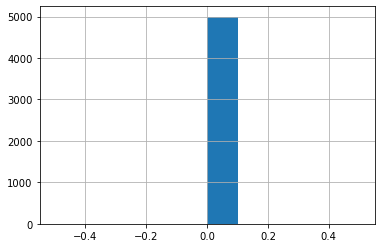

In [91]:
listings_osm["ferry_terminal"] = (listings_osm["ferry_terminal"] > 0).astype(int)

listings_osm["ferry_terminal"].hist()

In [92]:
del listings_osm["ferry_terminal"]

## Entertainment, Arts & Culture

In [93]:
# Set up query
query = {'amenity': "casino"}

#Run query, # does not work
casino_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

casino_gdf['geometry'] = casino_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
casino_gdf['geometry'] = casino_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
casino_gdf = casino_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = casino_gdf.geometry.apply(lambda x: x.x).values
Lat = casino_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['casinos'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [94]:
# Set up query
query = {'amenity': "cinema"}

#Run query, # does not work
cinema_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

cinema_gdf['geometry'] = cinema_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
cinema_gdf['geometry'] = cinema_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
cinema_gdf = cinema_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = cinema_gdf.geometry.apply(lambda x: x.x).values
Lat = cinema_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['cinemas'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [95]:
# Set up query
query = {'amenity': "nightclub"}

#Run query, # does not work
nightclub_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

nightclub_gdf['geometry'] = nightclub_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
nightclub_gdf['geometry'] = nightclub_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
nightclub_gdf = nightclub_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = nightclub_gdf.geometry.apply(lambda x: x.x).values
Lat = nightclub_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['nightclubs'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [96]:
# Set up query
query = {'amenity': ["social_centre", "public_bookcase", "community_centre"]}

#Run query, # does not work
social_amenities_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

social_amenities_gdf['geometry'] = social_amenities_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
social_amenities_gdf['geometry'] = social_amenities_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
social_amenities_gdf = social_amenities_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = social_amenities_gdf.geometry.apply(lambda x: x.x).values
Lat = social_amenities_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['social_amenities'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [97]:
# Set up query
query = {'amenity': ["stripclub", "swingerclub", "love_hotel", "brothel"]}

#Run query, # does not work
sex_amenities_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

sex_amenities_gdf['geometry'] = sex_amenities_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
sex_amenities_gdf['geometry'] = sex_amenities_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
sex_amenities_gdf = sex_amenities_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = sex_amenities_gdf.geometry.apply(lambda x: x.x).values
Lat = sex_amenities_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['sex_amenities'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [98]:
# Set up query
query = {'amenity': ["theatre", "arts_centre"]}

#Run query, # does not work
culture_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

culture_gdf['geometry'] = culture_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
culture_gdf['geometry'] = culture_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
culture_gdf = culture_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = culture_gdf.geometry.apply(lambda x: x.x).values
Lat = culture_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['theatres_artscentre'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

array([[<AxesSubplot:title={'center':'casinos'}>,
        <AxesSubplot:title={'center':'cinemas'}>],
       [<AxesSubplot:title={'center':'nightclubs'}>,
        <AxesSubplot:title={'center':'social_amenities'}>],
       [<AxesSubplot:title={'center':'sex_amenities'}>,
        <AxesSubplot:title={'center':'theatres_artscentre'}>]],
      dtype=object)

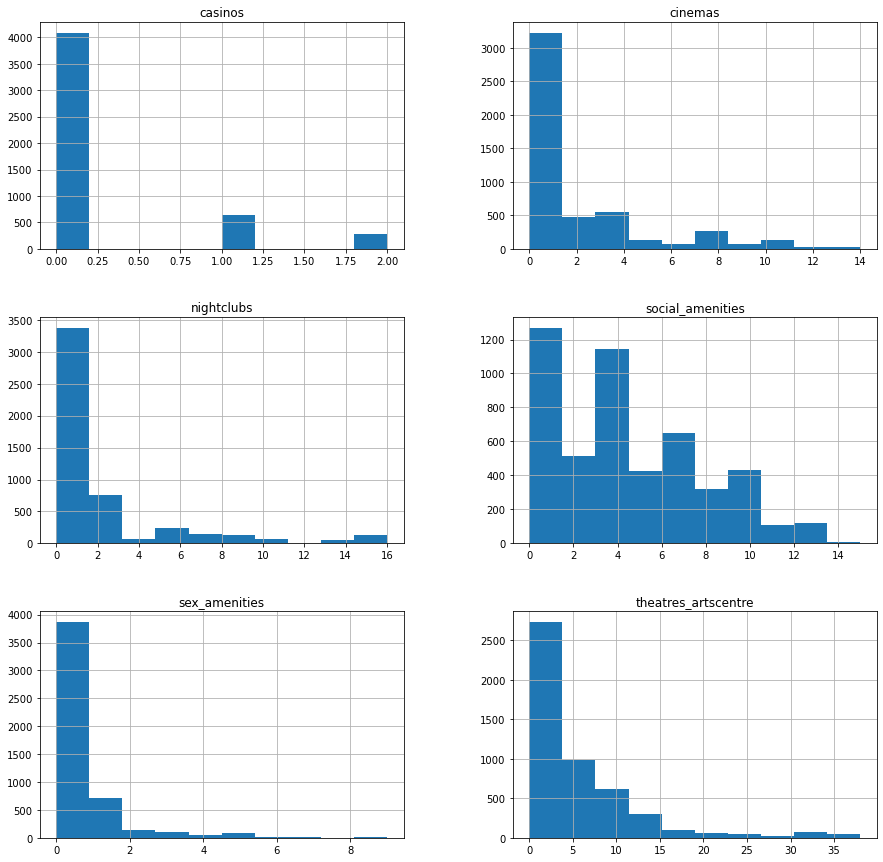

In [99]:
listings_osm[['casinos', 'cinemas', 'nightclubs', 'social_amenities', 'sex_amenities',
              'theatres_artscentre']].hist(figsize = (15,15), bins = 10)

# Commercials

In [100]:
# Set up query
query = {'shop': "mall"}

#Run query, # does not work
mall_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

mall_gdf['geometry'] = mall_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
mall_gdf['geometry'] = mall_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
mall_gdf = mall_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = mall_gdf.geometry.apply(lambda x: x.x).values
Lat = mall_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['malls'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [101]:
# Set up query
query = {'building': "kiosk", "shop": "kiosk"}

#Run query, # does not work
kiosk_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

kiosk_gdf['geometry'] = kiosk_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
kiosk_gdf['geometry'] = kiosk_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
kiosk_gdf = kiosk_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = kiosk_gdf.geometry.apply(lambda x: x.x).values
Lat = kiosk_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['kiosks'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [102]:
# Set up query
query = {'building': "supermarket", "shop": "supermarket"}

#Run query, # does not work
supermarket_gdf = ox.geometries_from_place(
            "München, Bayern, Deutschland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

supermarket_gdf['geometry'] = supermarket_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
supermarket_gdf['geometry'] = supermarket_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
supermarket_gdf = supermarket_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = supermarket_gdf.geometry.apply(lambda x: x.x).values
Lat = supermarket_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['supermarkets'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

array([[<AxesSubplot:title={'center':'malls'}>,
        <AxesSubplot:title={'center':'kiosks'}>],
       [<AxesSubplot:title={'center':'supermarkets'}>, <AxesSubplot:>]],
      dtype=object)

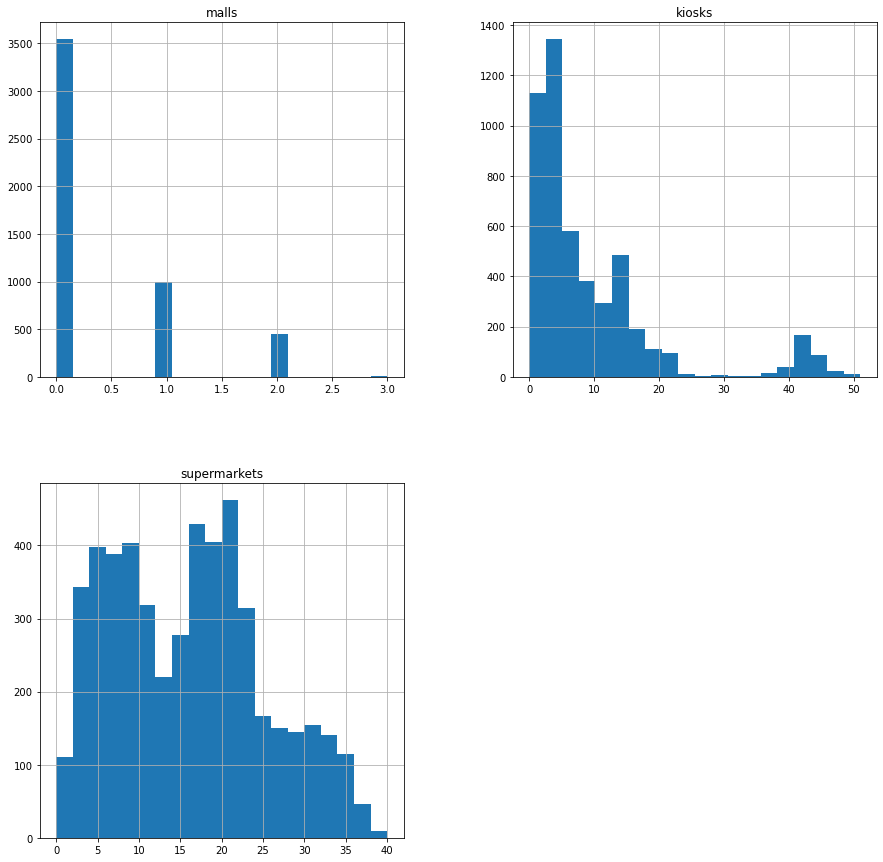

In [103]:
listings_osm[["malls", "kiosks", "supermarkets"]].hist(figsize = (15,15), bins = 20)

<AxesSubplot:>

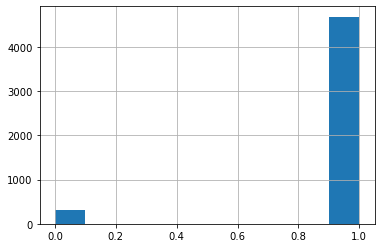

In [104]:
listings_osm["kiosks"] = (listings_osm["kiosks"] > 0).astype(int)
listings_osm["kiosks"].hist()

# Distances

https://github.com/QuangTrungNguyen/Airbnb-pricing-prediction/blob/master/exploratory-data-analysis/Exploratory%20Data%20Analysis.ipynb
Top10 from Tripadvisor + TempleBar + Airport + Main station + Harbour

In [105]:
# Set up Api

geolocator = geopy.geocoders.Nominatim(user_agent="1241ae50-7544-11ec-89e4-27bc646f8191")

In [120]:
# Geodata
Temple_Bar = (geolocator.geocode("Marienplatz, München").latitude, geolocator.geocode("Marienplatz, München").longitude) 
Jameson_Distillery = (geolocator.geocode("Englischer Garten, München").latitude, geolocator.geocode("Englischer Garten, München").longitude)
Irish_Whiskey_Museum = (geolocator.geocode("Schloss Nymphenburg, München").latitude, geolocator.geocode("Schloss Nymphenburg, München").longitude)
EPIC_Irish_Emigration = (geolocator.geocode("Munich Residenz, München").latitude, geolocator.geocode("Munich Residenz, München").longitude)
Little_Museum_Dublin = (geolocator.geocode("Allianz Arena, München").latitude, geolocator.geocode("Allianz Arena, München").longitude) 
Kilmainham_Gaol = (geolocator.geocode("Viktualienmarkt, München").latitude, geolocator.geocode("Viktualienmarkt, München").longitude) 
Teeling_Whiskey = (geolocator.geocode("BMW-Museum, München").latitude, geolocator.geocode("BMW-Museum, München").longitude) 
Glasnevin_cemetery = (geolocator.geocode("Olympiapark, München").latitude, geolocator.geocode("Olympiapark, München").longitude) 
Trinity_College = (geolocator.geocode("Alte Pinakothek, München").latitude, geolocator.geocode("Alte Pinakothek, München").longitude) 
Guinnes_Storehouse = (geolocator.geocode("Oktoberfest, München").latitude, geolocator.geocode("Oktoberfest, München").longitude) 
National_Museum = (geolocator.geocode("Peterskirche, München").latitude, geolocator.geocode("Peterskirche, München").longitude) 

Airport = (geolocator.geocode("Airport, München").latitude, geolocator.geocode("Airport, München").longitude) 
heuston_station = (geolocator.geocode("Hauptbahnhof, München").latitude, geolocator.geocode("Hauptbahnhof, München").longitude) 
docks = (geolocator.geocode("Busbahnhof, München").latitude, geolocator.geocode("Busbahnhof, München").longitude) 

In [121]:
for index, row in listings.iterrows():
    coords = (row['latitude'], row['longitude'])

    # Sights
    dist_Temple_Bar = geopy.distance.geodesic(Temple_Bar, coords).m
    dist_Jameson_Distillery = geopy.distance.geodesic(Jameson_Distillery, coords).m
    dist_Irish_Whiskey_Museum = geopy.distance.geodesic(Irish_Whiskey_Museum, coords).m
    dist_EPIC_Irish_Emigration = geopy.distance.geodesic(EPIC_Irish_Emigration, coords).m
    dist_Little_Museum_Dublin = geopy.distance.geodesic(Little_Museum_Dublin, coords).m
    dist_Kilmainham_Gaol = geopy.distance.geodesic(Kilmainham_Gaol, coords).m
    dist_Teeling_Whiskey = geopy.distance.geodesic(Teeling_Whiskey, coords).m
    dist_Glasnevin_cemetery = geopy.distance.geodesic(Glasnevin_cemetery, coords).m
    dist_Trinity_College = geopy.distance.geodesic(Trinity_College, coords).m
    dist_Guinnes_Storehouse = geopy.distance.geodesic(Guinnes_Storehouse, coords).m
    dist_National_Museum = geopy.distance.geodesic(National_Museum, coords).m

    #Travel locations
    dist_Airport = geopy.distance.geodesic(Airport, coords).m
    dist_heuston_station = geopy.distance.geodesic(heuston_station, coords).m
    dist_docks = geopy.distance.geodesic(docks, coords).m

    distances_sights = [dist_Temple_Bar, dist_Jameson_Distillery, dist_Irish_Whiskey_Museum, dist_EPIC_Irish_Emigration,
                        dist_Little_Museum_Dublin, dist_Kilmainham_Gaol, dist_Teeling_Whiskey, dist_Glasnevin_cemetery,
                        dist_Trinity_College, dist_Guinnes_Storehouse, dist_National_Museum]
    distances_sights.sort()
    
    mean_dist_sight = mean([dist_Temple_Bar, dist_Jameson_Distillery, dist_Irish_Whiskey_Museum, dist_EPIC_Irish_Emigration,
                        dist_Little_Museum_Dublin, dist_Kilmainham_Gaol, dist_Teeling_Whiskey, dist_Glasnevin_cemetery,
                        dist_Trinity_College, dist_Guinnes_Storehouse, dist_National_Museum])

    nearest_travel_poss = min(dist_Airport, dist_heuston_station, dist_docks)

    mean_dist_travel = mean([dist_Airport, dist_heuston_station, dist_docks])

    listings_osm.at[index, 'nearest_sight'] = distances_sights[0]
    listings_osm.at[index, '2nd_nearest_sight'] = distances_sights[1]
    listings_osm.at[index, '3rd_nearest_sight'] = distances_sights[2]

    listings_osm.at[index, 'mean_dist_sight'] = mean_dist_sight

    listings_osm.at[index, 'nearest_travel_poss'] = nearest_travel_poss
    listings_osm.at[index, 'mean_dist_travel'] = mean_dist_travel

array([[<AxesSubplot:title={'center':'nearest_sight'}>,
        <AxesSubplot:title={'center':'2nd_nearest_sight'}>],
       [<AxesSubplot:title={'center':'3rd_nearest_sight'}>,
        <AxesSubplot:title={'center':'mean_dist_sight'}>],
       [<AxesSubplot:title={'center':'nearest_travel_poss'}>,
        <AxesSubplot:title={'center':'mean_dist_travel'}>]], dtype=object)

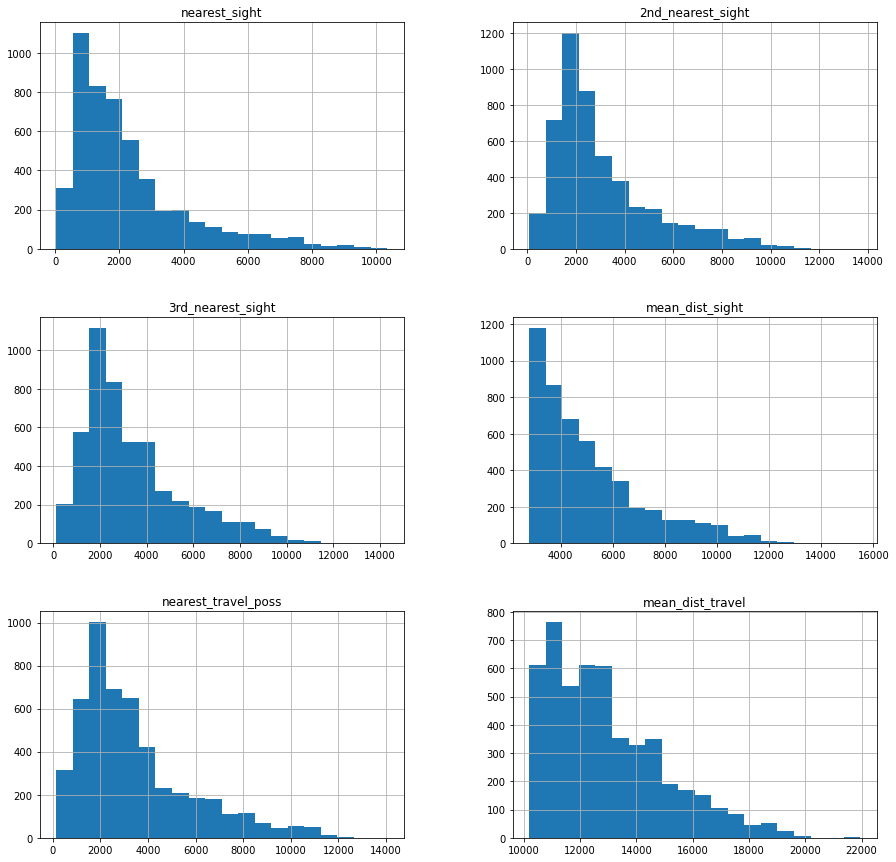

In [122]:
listings_osm[['nearest_sight', "2nd_nearest_sight", "3rd_nearest_sight", 
              'mean_dist_sight', 'nearest_travel_poss', 'mean_dist_travel']].hist(figsize = (15,15), bins = 20)

In [123]:
listings_osm

,id,in_city,bars,cafes,fast_foods,restaurants,library,university,bus_train_tram_station,bicycle_rentals,...,theatres_artscentre,malls,kiosks,supermarkets,nearest_sight,2nd_nearest_sight,3rd_nearest_sight,mean_dist_sight,nearest_travel_poss,mean_dist_travel
0,97945,1,4,5,4,14,3,0,41,0,...,0,0,1,8,4817.178204,4926.335381,6753.155097,7843.019265,5738.708060,16400.457582
1,114695,1,6,2,5,8,1,0,38,3,...,0,0,1,4,4904.427689,4933.053134,4935.384592,6952.242091,6445.247629,14599.199370
2,127383,1,50,89,67,167,13,35,72,11,...,7,0,1,27,562.601209,1561.054134,1857.228740,2920.631339,1404.597360,10867.082987
3,159634,1,5,3,10,18,1,0,42,0,...,1,1,1,5,3544.267516,6270.811174,7125.638106,8315.224210,6736.111965,16272.717239
4,170154,1,11,5,10,22,1,1,48,1,...,0,0,1,13,3059.158613,4659.530711,4801.161983,6530.469446,4215.922525,15357.844838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4990,53933449,1,3,1,4,8,1,1,32,0,...,0,0,0,11,1998.106112,5292.439001,5606.793505,7005.012959,5553.048780,14853.478423
4991,53935376,0,2,1,3,3,0,0,18,1,...,0,0,1,1,4820.108595,7217.500404,8383.684563,9444.199618,7799.025342,17473.672252
4992,53936793,1,10,12,35,35,2,1,69,1,...,4,2,1,16,3071.600938,6271.594269,6726.784331,8079.177062,6623.997902,15898.040901
4993,53945865,1,13,3,9,22,0,0,46,6,...,1,0,1,4,434.155974,867.147631,2851.154958,3681.927684,764.417603,10277.781126


Get three minimum distances

# Correlations

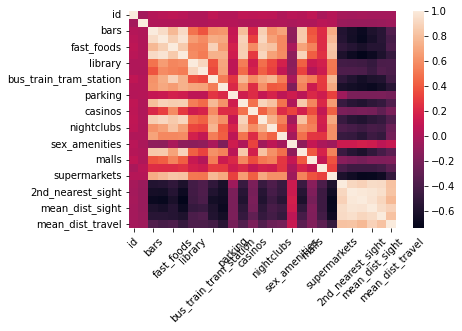

In [124]:
corr_mat = listings_osm.corr().round(2)
g = sns.heatmap(corr_mat)#, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment ="center")
plt.show()

In [125]:
# We see some high correlations
c = listings_osm.corr().abs()
# Set the diagonal to 0, so we do not look at self correlations
sol = (c.where(np.triu(np.ones(c.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

# Those destinations are quite close (see maps)
sol[sol > 0.9]

C:\Users\49173\anaconda3\envs\geo2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


2nd_nearest_sight  3rd_nearest_sight      0.976103
                   mean_dist_sight        0.969381
cafes              restaurants            0.963306
3rd_nearest_sight  mean_dist_sight        0.959397
2nd_nearest_sight  nearest_travel_poss    0.935335
bars               cafes                  0.934370
mean_dist_sight    nearest_travel_poss    0.929931
nearest_sight      mean_dist_sight        0.928346
bars               restaurants            0.921506
nearest_sight      nearest_travel_poss    0.918002
                   2nd_nearest_sight      0.914989
cafes              cinemas                0.911019
dtype: float64

In [126]:
listings_osm.head(10)

,id,in_city,bars,cafes,fast_foods,restaurants,library,university,bus_train_tram_station,bicycle_rentals,...,theatres_artscentre,malls,kiosks,supermarkets,nearest_sight,2nd_nearest_sight,3rd_nearest_sight,mean_dist_sight,nearest_travel_poss,mean_dist_travel
0,97945,1,4,5,4,14,3,0,41,0,...,0,0,1,8,4817.178204,4926.335381,6753.155097,7843.019265,5738.708060,16400.457582
1,114695,1,6,2,5,8,1,0,38,3,...,0,0,1,4,4904.427689,4933.053134,4935.384592,6952.242091,6445.247629,14599.199370
2,127383,1,50,89,67,167,13,35,72,11,...,7,0,1,27,562.601209,1561.054134,1857.228740,2920.631339,1404.597360,10867.082987
3,159634,1,5,3,10,18,1,0,42,0,...,1,1,1,5,3544.267516,6270.811174,7125.638106,8315.224210,6736.111965,16272.717239
4,170154,1,11,5,10,22,1,1,48,1,...,0,0,1,13,3059.158613,4659.530711,4801.161983,6530.469446,4215.922525,15357.844838
5,170815,1,10,12,6,47,0,2,44,4,...,6,0,1,10,1041.895355,2155.388154,2427.667891,3618.646387,2256.653249,11002.874987
6,172672,1,13,26,18,81,3,3,71,7,...,1,0,1,17,1156.117144,1538.657982,1745.996630,3242.098361,1859.979649,10523.607252
7,179640,1,2,4,5,16,0,0,49,0,...,0,0,1,3,3244.831375,4434.180941,4671.712489,5993.391590,6070.915917,13103.761562
8,183634,1,0,1,0,0,0,0,11,0,...,0,0,0,0,4715.562163,7848.574503,8465.936412,9878.390962,8213.165253,16587.403973
9,186596,1,39,46,18,71,1,0,73,4,...,4,0,1,18,1700.255143,1821.928071,1887.493360,4501.131155,2773.619257,13361.748247


In [127]:
listings_osm.to_csv("StreetData_munich.csv")